In [253]:
import pandas as pd
import numpy as np

import sympy
from sympy import ordered, Matrix, hessian, Trace
from sympy.vector import laplacian, divergence, gradient, curl, CoordSys3D, Del
from sympy.plotting import plot3d 

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
plotly.offline.init_notebook_mode()


Index(['X', 'Y', 'Z', 'Color', 'DeformX', 'DeformY', 'DeformZ'], dtype='object')


X         Y    Z  Color       DeformX       DeformY       DeformZ
0    -5.000000 -3.000000  1.0    1.0 -1.350400e-09 -1.232790e-09  1.105351e-08
1    -5.000000 -3.285714  1.0    1.0 -1.344756e-09 -1.304227e-09  1.077692e-08
2    -4.810628 -3.069161  1.0    1.0 -1.337891e-09 -1.234747e-09  1.115857e-08
3    -4.810628 -3.354876  1.0    1.0 -1.331402e-09 -1.304986e-09  1.087887e-08
4    -5.000000 -3.571429  1.0    1.0 -1.339174e-09 -1.371300e-09  1.048351e-08
...        ...       ...  ...    ...           ...           ...           ...
1732  3.677487  4.808763  1.0    1.0 -7.654584e-10  1.690758e-09  8.547645e-09
1733  3.857143  5.000000  1.0    1.0 -7.946203e-10  1.707593e-09  8.213078e-09
1734  3.391773  4.808763  1.0    1.0 -7.753082e-10  1.713730e-09  8.580794e-09
1735  3.571429  5.000000  1.0    1.0 -8.040129e-10  1.730336e-09  8.240034e-09
1736  3.285714  5.000000  1.0    1.0 -8.139389e-10  1.753037e-09  8.264217e-09

[1737 rows x 7 columns]

Text(0, 0.5, 'Deformation: H(x,y)')

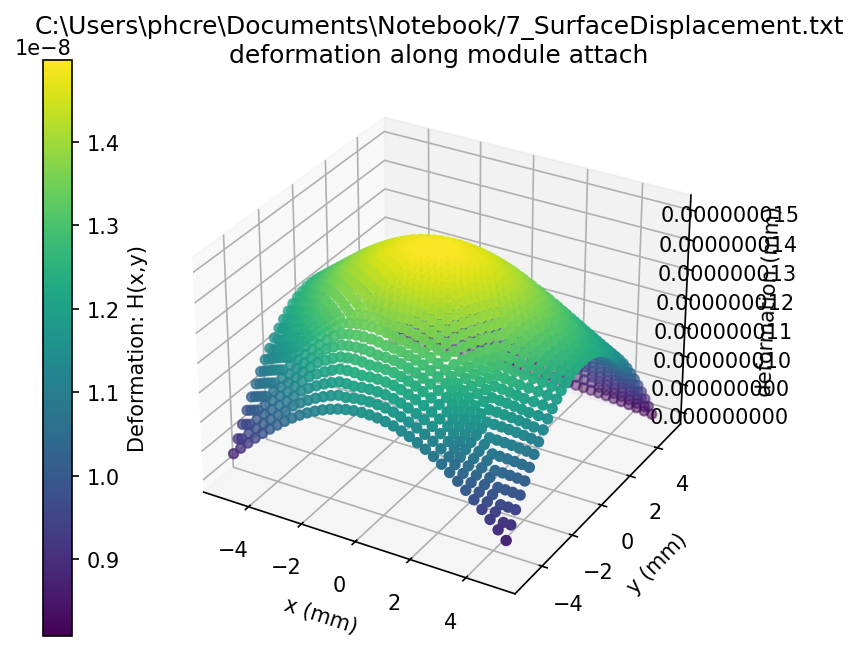

In [254]:
## Open Tab-seperated file with lsit of X,Y,z positions of data

folder = "C:\\Users\\phcre\\Documents\\Notebook"
filename = f"{folder}/7_SurfaceDisplacement.txt"

# C_NODE = "Node Number"
C_X = "X" # mm
C_Y = "Y" # mm
C_Z = "Z" # mm
C_DEFC = "Color" # deformation in mm
C_DEFX = "DeformX" # deformation in X in mm
C_DEFY = "DeformY" # deformation in Y in mm
C_DEFZ = "DeformZ" # deformation in Z in

C_DEF=C_DEFZ

# df = pd.read_csv(filename, sep="\t")
df = pd.read_csv(filename, delim_whitespace=True, skiprows=8, names=[C_X, C_Y, C_Z, C_DEFC, C_DEFX, C_DEFY, C_DEFZ])
cols = df.columns
print(cols)
display(df)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
# ax = plt.axes(projection='3d')
pcm = ax.scatter(df[C_X], df[C_Y], df[C_DEF], c=df[C_DEF], cmap='viridis')

ax.ticklabel_format(style='plain', axis='z', scilimits=(0, 0))
ax.set_title(f'{filename}\ndeformation along module attach')
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.set_zlabel('deformation (mm)')
# ax.view_init(70, -145)

cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8]) 
fig.colorbar(pcm, cax = cbaxes)
plt.ylabel("Deformation: H(x,y)")

In [255]:
fig = go.Figure(data=[go.Scatter3d(x=df[C_X], y=df[C_Y], z=df[C_DEF],
    mode='markers', 
    marker=dict(
        size=1,
        color=df[C_DEF],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        colorbar=dict(orientation='v'),
        opacity=0.8
    ))])
    
fig.update_layout(title=f'{filename}\ndeformation along module attach', autosize=False, width=500, height=500, margin=dict(l=0, r=0, b=0), coloraxis_showscale=True)
fig.show()

Range = Min: (-5.0,-5.0)  Max: (5.0,5.0)
Note: Matrix forms have flipped y axis (upside-down)


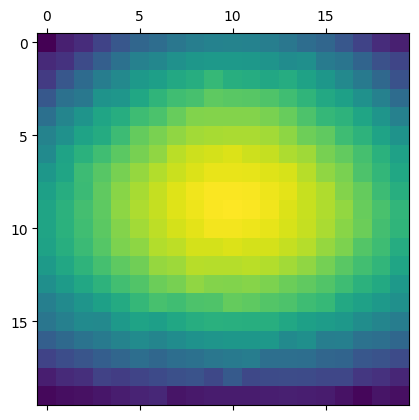

In [256]:
# Find bounding box of data
x_min = df.iloc[0][C_X]
y_min = df.iloc[0][C_Y]
x_max = df.iloc[0][C_X]
y_max = df.iloc[0][C_Y]
for index, row in df.iterrows():
    # print(row[C_X], row[C_Y])
    x = float(row[C_X])
    y = float(row[C_Y])
    if y > y_max:
        y_max = y
    if x > x_max:
        x_max = x
    if y < y_min:
        y_min = y
    if x < x_min:
        x_min = x

print(f"Range = Min: ({x_min},{y_min})  Max: ({x_max},{y_max})")

resolution = 0.5
x_steps = np.arange(x_min, x_max, resolution)
y_steps = np.arange(y_min, y_max, resolution)
nx = len(x_steps)
ny = len(y_steps)

data = []
for p_x in x_steps:
    for p_y in y_steps:
        df_closest = (
            df.copy(deep=True)
            .assign(d=(p_x - df[C_X]) ** 2 + (p_y - df[C_Y]) ** 2)
            .sort_values("d")
            .drop("d", axis=1)
        )
        # biased average
        # sum_dist = sum([(p_x - df_closest.iloc[i][C_X]) ** 2 + (p_y - df_closest.iloc[i][C_Y]) ** 2 for i in range(0,2)])
        # avg = (
        #     sum([df_closest.iloc[i][C_DEF] * ( (p_x - df_closest.iloc[i][C_X]) ** 2 + (p_y - df_closest.iloc[i][C_Y]) ** 2 )/sum_dist for i in range (0,2)])
        #     # / sum_dist
        # )
        # data.append({C_X: p_x, C_Y: p_y, C_DEF: avg})
        data.append({C_X: p_x, C_Y: p_y, C_DEF: df_closest.iloc[0][C_DEF]})

df_ortho = pd.DataFrame(data)

Z = np.empty((len(y_steps),0))
for x_pos in x_steps:
    col = []
    for y_pos in y_steps:
        df_val = df_ortho.loc[(df_ortho[C_X] == x_pos) & (df_ortho[C_Y] == y_pos)]
        col.append(df_val[C_DEF])
    npcol = np.vstack(col)
    Z = np.append(Z,npcol,1)

print("Note: Matrix forms have flipped y axis (upside-down)")
plt.matshow(Z)


In [257]:
## Generated Z test data

# fstr = "x**2+y**2"
# x_min =-5
# x_max=5
# y_min=-5
# y_max=5
# resolution = 0.5
# x_steps = np.arange(x_min, x_max, resolution)
# y_steps = np.arange(y_min, y_max, resolution)
# nx = len(x_steps)
# ny = len(y_steps)
# f = sympy.parsing.sympy_parser.parse_expr(fstr, evaluate=False)
# print(f)
# v = list(ordered(f.free_symbols)); v

# x = np.linspace(x_min, x_max, nx)
# y = np.linspace(y_min, y_max, ny)

# Z = np.empty(shape=(ny, nx))

# for i in range(len(x)):
#     for j in range(len(y)):
#         Z[j, i] = f.subs({v[0]: x[i], v[1]: y[j]})

# np.random.seed(42)
# noise_sigma = 0.001
# Z += noise_sigma * np.random.randn(*Z.shape)
# plt.matshow(Z)

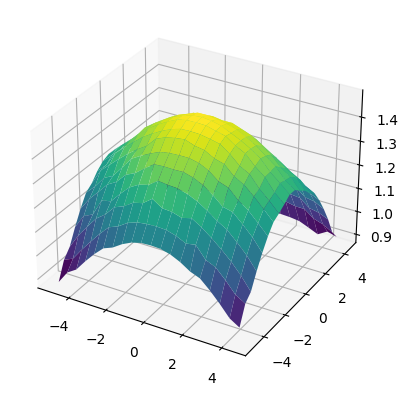

In [258]:
X, Y = np.meshgrid(x_steps, y_steps)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

In [259]:
fig = go.Figure(go.Surface(x=X, y=Y, z=Z))
fig.update_traces(contours_z=dict(show=True, usecolormap=True, project_z=True, width=10, start=0, end=0.03, size=0.001))
fig.update_layout(title='', autosize=False, width=500, height=500, margin=dict(l=0, r=0, b=0), coloraxis_showscale=True)
fig.show()

The polynomial regression model: 1, x, x^2, ..., xy, x^2y, ... etc.

$$
z_i \,=\, c_0 + c_1 x_i + c_2 x_i^2 + \cdots + c_{i} y_{i} + c_{i} x_{i} y_{i} + c_i x_i^2 y_i + \cdots + c_m x_i^m y_i^m + \varepsilon_i\  (i = 1, 2, \dots , n) 
$$

can be expressed in matrix form in terms of a design matrix $\mathbf{A}$, a response vector $\vec y$, a parameter vector $\vec c$, and a vector $\vec\varepsilon$ of random errors. The ''i''-th row of $\mathbf{A}$ and $\vec y$ will contain the ''x'' and ''y'' value for the ''i''-th data sample. Then the model can be written as a system of linear equations:

$$
 \begin{bmatrix} z_1\\ z_2\\ z_3 \\ \vdots \\ z_n \end{bmatrix}= \begin{bmatrix} 1 & x_1 & x_1^2 & \dots & x_1^m y_1^m \\ 1 & x_2 & x_2^2 &  \dots & x_2^m y_2^m \\ 1 & x_3 & x_3^2 & \dots & x_3^m y_3^m \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_n & x_n^2 & \dots & x_n^m y_n^m \end{bmatrix} \begin{bmatrix} c_0\\ c_1\\ c_2\\ \vdots \\ c_{m^2} \end{bmatrix} + \begin{bmatrix} \varepsilon_1\\ \varepsilon_2\\ \varepsilon_3 \\ \vdots \\ \varepsilon_n \end{bmatrix}, 
$$

which when using pure matrix notation is written as

$$
\vec z = \mathbf{A} \vec c + \vec\varepsilon
$$

f(x,y) = 1.4850420081278197e-08 * x**0 * y**0 + -7.337826020274968e-13 * x**1 * y**0 + -1.1690416794599563e-10 * x**2 * y**0 + 9.886840186620973e-14 * x**3 * y**0 + 6.973059199447176e-13 * x**4 * y**0 + -3.030331856823055e-10 * x**0 * y**1 + -1.805546068203296e-12 * x**1 * y**1 + 9.953399642056237e-12 * x**2 * y**1 + 8.389122511274613e-14 * x**3 * y**1 + -2.2381404723838215e-10 * x**0 * y**2 + -1.1066809821848037e-13 * x**1 * y**2 + 1.6954641287939997e-12 * x**2 * y**2 + -2.8509030940385886e-13 * x**0 * y**3 + -3.7597347954914374e-14 * x**1 * y**3 + 1.1156687679050004e-12 * x**0 * y**4
RMS residual = 7.754889164168884e-11


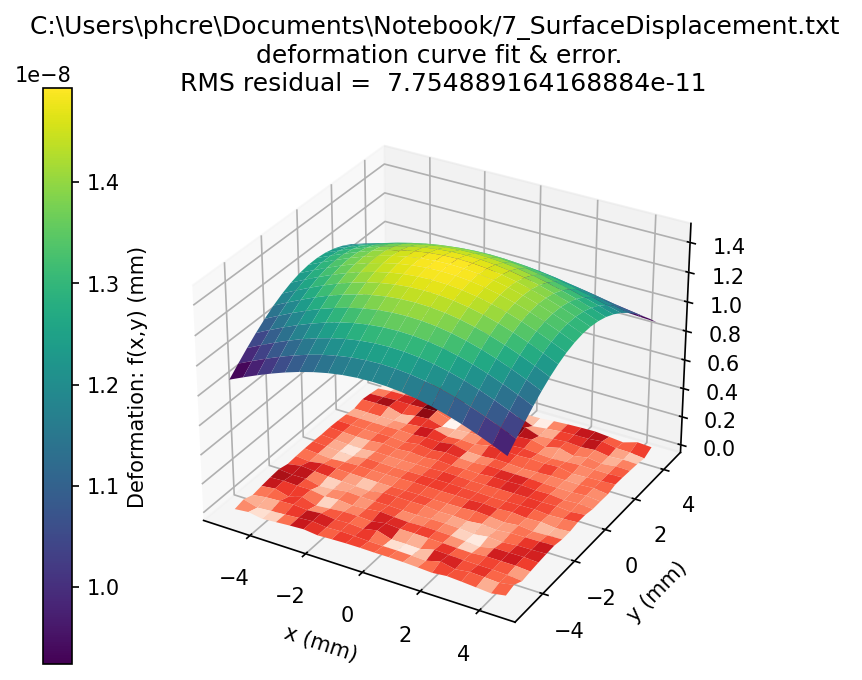

In [260]:
# https://scipython.com/blog/linear-least-squares-fitting-of-a-two-dimensional-data/


def get_basis(x, y, max_order=4):
    """Return the fit basis polynomials: 1, x, x^2, ..., xy, x^2y, ... etc."""
    basis = []
    for i in range(max_order+1):
        for j in range(max_order - i +1):
            basis.append(x**j * y**i)
    return basis

def get_basis_str(x, y, max_order=4):
    """Return the fit basis polynomials: 1, x, x^2, ..., xy, x^2y, ... etc."""
    basis_str = []
    for i in range(max_order+1):
        for j in range(max_order - i +1):
            basis_str.append(f'x**{j} * y**{i}')
    return basis_str

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
x, y = X.ravel(), Y.ravel()
# Maximum order of polynomial term in the basis.
max_order = 4
basis = get_basis(x, y, max_order)
# Linear, least-squares fit.
A = np.vstack(basis).T
b = Z.ravel()

# https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
c, r, rank, s = np.linalg.lstsq(A, b, rcond=None)
# c is our basis coefficients

basis_str = get_basis_str(x, y, max_order)
fstr = ' + '.join([f'{c[i]} * {basis_str[i]}' for i in range(len(c))])
print("f(x,y) =", fstr)

# Calculate the fitted surface from the coefficients, c.
fit = np.sum(c[:, None, None] * np.array(get_basis(X, Y, max_order))
                .reshape(len(basis), *X.shape), axis=0)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
plt.title(f'{filename} \n deformation curve fit & error. \n RMS residual =  {rms}')
pcm = ax.plot_surface(X, Y, fit, cmap='viridis')
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
# Adding the colorbar
cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8]) 
fig.colorbar(pcm, cax = cbaxes)
plt.ylabel("Deformation: f(x,y) (mm)")
pcm = ax.plot_surface(X, Y, Z-fit, cmap='Reds')
# Add Labels

In [261]:
## 2D Gaussian Distribution Test
# fstr = "(1/(2*pi*1**2))*exp(-(x**2+y**2)/(2*1**2))"
# fstr = "-0.012233051892616125 * x**0 * y**0 + -0.000329373619938677 * x**1 * y**0 + 3.3782558542436995e-05 * x**2 * y**0 + -1.0023939893806668e-06 * x**3 * y**0 + 9.16128937360032e-09 * x**4 * y**0 + 0.002709676092513422 * x**0 * y**1 + 0.00011714893909836583 * x**1 * y**1 + -2.437628856953166e-06 * x**2 * y**1 + 2.283316500554123e-09 * x**3 * y**1 + -8.241336609688418e-05 * x**0 * y**2 + -3.7136880079460383e-06 * x**1 * y**2 + 7.363885255969092e-08 * x**2 * y**2 + 1.580578402319046e-06 * x**0 * y**3 + -7.13177359277172e-10 * x**1 * y**3 + -1.5600859255057026e-08 * x**0 * y**4"
# x_min =5
# x_max=45
# y_min=12
# y_max=36
# resolution = 0.5
# x_steps = np.arange(x_min, x_max, resolution)
# y_steps = np.arange(y_min, y_max, resolution)
# nx = len(x_steps)
# ny = len(y_steps)

In [262]:
f = sympy.parsing.sympy_parser.parse_expr(fstr, evaluate=False)
f

6.973059199447176e-13*x**4*y**0 + 8.389122511274613e-14*x**3*y**1 + 9.886840186620973e-14*x**3*y**0 + 1.6954641287939997e-12*x**2*y**2 + 9.953399642056237e-12*x**2*y**1 - 1.1690416794599563e-10*x**2*y**0 - 3.7597347954914374e-14*x**1*y**3 - 1.1066809821848037e-13*x**1*y**2 - 1.805546068203296e-12*x**1*y**1 - 7.337826020274968e-13*x**1*y**0 + 1.1156687679050004e-12*x**0*y**4 - 2.8509030940385886e-13*x**0*y**3 - 2.2381404723838215e-10*x**0*y**2 - 3.030331856823055e-10*x**0*y**1 + 1.4850420081278197e-8*x**0*y**0

In [263]:
# get our variables
v = list(ordered(f.free_symbols))
v

[x, y]

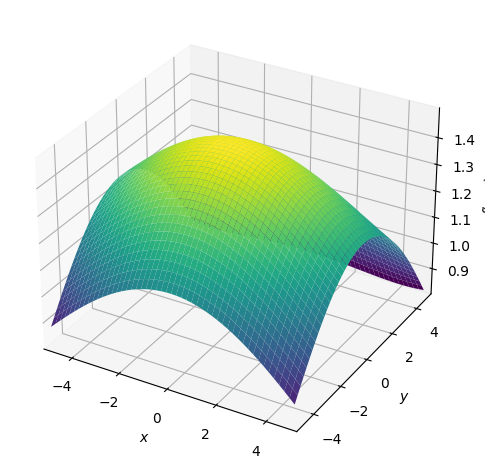

In [264]:
pcm = plot3d(f, (v[0], x_min, x_max), (v[1], y_min, y_max))

In [265]:
def gradient(f: sympy.Function, vars: list[sympy.Symbol]) -> sympy.Matrix:
    return sympy.Matrix([f]).jacobian(sympy.Matrix(vars))

def curvature_explicit(
    h: sympy.Function, vars: tuple[sympy.Symbol], point: tuple = None
):
    """
    h is an sympy expression of explicit definition: h(u, v) = z
    alternatively though of as a monge patch (u, v) ↦ (u, v, h(u, v))
    vars is list or tuple of sympy symbols: (u, v)
    point is a tuple of (u, v) values to evaluate the curvature at
    """
    # https://en.wikipedia.org/wiki/Differential_geometry_of_surfaces

    u, v = vars

    h_u = sympy.diff(h, u)
    h_v = sympy.diff(h, v)
    h_uu = sympy.diff(h_u, u)
    h_uv = sympy.diff(h_u, v)
    # h_vu = sympy.diff(h_v, u)
    h_vv = sympy.diff(h_v, v)

    ## alternatively
    # h_u, h_v = gradient(h, vars)
    # h_uu, h_uv = gradient(f_u, vars)
    # h_vu, h_vv = gradient(f_v, vars)

    # Shape operator
    P = sympy.Matrix(
        [
            [
                h_uu * (1 + h_v**2 - h_uv * h_u * h_v),
                h_uv * (1 + h_u**2 - h_uu * h_u * h_v),
            ],
            [
                h_uv * (1 + h_v**2 - h_vv * h_u * h_v),
                h_vv * (1 + h_u**2 - h_uv * h_u * h_v),
            ],
        ]
    ) / ((1 + h_u**2 + h_v**2) ** (3 / 2))
    # Gaussian curvature
    K = (h_uu * h_vv - h_uv**2) / ((1 + h_u**2 + h_v**2) ** 2)
    # Mean curvature
    H = (
        ((1 + h_u**2) * h_vv - 2 * h_u * h_v * h_uv + (1 + h_v**2) * h_uu)
        / ((1 + h_u**2 + h_v**2) ** (3 / 2))
    ) / 2

    if point is None:
        X = P.eigenvects()
    else:
        X = P.subs({u: point[0], v: point[1]}).eigenvects()
        K = K.subs({u: point[0], v: point[1]})
        H = H.subs({u: point[0], v: point[1]})

    k1 = X[0][0]
    k2 = X[1][0]
    X1 = X[0][2][0]
    X2 = X[1][2][0]

    dh = gradient(sympy.Matrix([u, v, h]), vars)
    if point is None:
        k1vec = dh * X1
        k2vec = dh * X2
    else:
        k1vec = (dh * X1).subs({u: point[0], v: point[1]})
        k2vec = (dh * X2).subs({u: point[0], v: point[1]})

    ## alternatively
    # k1 = H + sympy.sqrt(H**2 - K)
    # k2 = H - sympy.sqrt(H**2 - K)

    return K, H, k1, k2, k1vec, k2vec


def curvature_discrete_parametric(X: np.array, Y: np.array, Z: np.array):
    # known by MATLAB as surfature
    # where X, Y, Z matrices have a shape (lr+1,lb+1)
    # https://github.com/sujithTSR/surface-curvature/blob/master/surface.py

    (lr, lb) = X.shape

    # First Derivatives
    Xv, Xu = np.gradient(X)
    Yv, Yu = np.gradient(Y)
    Zv, Zu = np.gradient(Z)

    # Second Derivatives
    Xuv, Xuu = np.gradient(Xu)
    Yuv, Yuu = np.gradient(Yu)
    Zuv, Zuu = np.gradient(Zu)

    Xvv, Xuv = np.gradient(Xv)
    Yvv, Yuv = np.gradient(Yv)
    Zvv, Zuv = np.gradient(Zv)

    # Reshape to 1D vectors (same as ravel?)
    Xu = np.reshape(Xu, lr * lb)
    Yu = np.reshape(Yu, lr * lb)
    Zu = np.reshape(Zu, lr * lb)
    Xv = np.reshape(Xv, lr * lb)
    Yv = np.reshape(Yv, lr * lb)
    Zv = np.reshape(Zv, lr * lb)
    Xuu = np.reshape(Xuu, lr * lb)
    Yuu = np.reshape(Yuu, lr * lb)
    Zuu = np.reshape(Zuu, lr * lb)
    Xuv = np.reshape(Xuv, lr * lb)
    Yuv = np.reshape(Yuv, lr * lb)
    Zuv = np.reshape(Zuv, lr * lb)
    Xvv = np.reshape(Xvv, lr * lb)
    Yvv = np.reshape(Yvv, lr * lb)
    Zvv = np.reshape(Zvv, lr * lb)

    Xu = np.c_[Xu, Yu, Zu]
    Xv = np.c_[Xv, Yv, Zv]
    Xuu = np.c_[Xuu, Yuu, Zuu]
    Xuv = np.c_[Xuv, Yuv, Zuv]
    Xvv = np.c_[Xvv, Yvv, Zvv]

    # % First fundamental Coefficients of the surface (E,F,G)
    E = np.einsum("ij,ij->i", Xu, Xu)
    F = np.einsum("ij,ij->i", Xu, Xv)
    G = np.einsum("ij,ij->i", Xv, Xv)

    m = np.cross(Xu, Xv, axisa=1, axisb=1)
    p = np.sqrt(np.einsum("ij,ij->i", m, m))
    n = m / np.c_[p, p, p]

    # % Second fundamental Coefficients of the surface (L,M,N)
    L = np.einsum("ij,ij->i", Xuu, n)
    M = np.einsum("ij,ij->i", Xuv, n)
    N = np.einsum("ij,ij->i", Xvv, n)

    # % Gaussian Curvature
    K = (L * N - M**2) / (E * G - F**2)

    # % Mean Curvature
    H = (E * N + G * L - 2 * F * M) / (2 * (E * G - F**2))

    # % Shape Operator as 3D a matrix of 2D matrices (2, 2, lr*lb)
    LMMN = np.array([[L, M], [M, N]])
    EFFG = np.array([[E, F], [F, G]])
    # reshape so that the 2D matrices are in the last dimension (lr*lb, 2, 2)
    LMMN = np.swapaxes(LMMN, 0, 2)
    EFFG = np.swapaxes(EFFG, 0, 2)

    P = LMMN * np.linalg.inv(EFFG)
    X = np.linalg.eig(P)

    # the result of eig is a tuple of (eigenvalues, eigenvectors)
    k1 = X[0][:, 0]  # all the first eigenvalues
    k2 = X[0][:, 1]  # all the second eigenvalues
    X1 = X[1][:, 0, :]  # all the first eigenvectors
    X2 = X[1][:, 1, :]  # all the second eigenvectors

    X1 = np.expand_dims(X1, 2)  # add a dimension to the end (lr*lb, 3, 1)
    X2 = np.expand_dims(X2, 2)  # add a dimension to the end (lr*lb, 3, 1)

    dX = np.dstack((Xu, Xv))

    # matrix multiplication of dX and X1 for each point
    k1vec = np.einsum("ijk,ikl->ilj", dX, X1)
    k2vec = np.einsum("ijk,ikl->ilj", dX, X2)

    # normalize the vectors
    k1vec = k1vec / np.linalg.norm(k1vec, axis=2, keepdims=True)
    k2vec = k2vec / np.linalg.norm(k2vec, axis=2, keepdims=True)

    # #% Principal Curvatures k1, k2 (alternative from gaussian and mean curvature)
    # k1 = H + np.sqrt(H**2 - K)
    # k2 = H - np.sqrt(H**2 - K)

    # reshape back to 2D x,y matrices
    K = np.reshape(K, (lr, lb))
    H = np.reshape(H, (lr, lb))
    k1 = np.reshape(k1, (lr, lb))
    k2 = np.reshape(k2, (lr, lb))
    k1vec = np.reshape(k1vec, (lr, lb, 3))
    k2vec = np.reshape(k2vec, (lr, lb, 3))

    return K, H, k1, k2, k1vec, k2vec


# TODO: DiffGeoOps off mesh

https://math.stackexchange.com/questions/1985889/why-how-does-the-determinant-of-the-hessian-matrix-combined-with-the-2nd-deriva 

((2.0037091096489903e-19*(0.00018741277892936364*x**3 + 0.0075753249168859248*x**2*y + 0.022235868938679636*x**2 - 0.00025197713292903689*x*y**2 - 0.00049446448774776349*x*y - 0.004033585225060129*x + 0.0099696045147399754*y**3 - 0.0019106730313952008*y**2 - y - 0.67697534945058168)**2 + 1)*(8.367671039336611e-12*x**2 + 5.033473506764768e-13*x*y + 5.932104111972584e-13*x + 3.3909282575879994e-12*y**2 + 1.990679928411247e-11*y - 2.3380833589199126e-10) + (5.4666337932582208e-20*(0.011929530523956015*x**3 + 0.0010764101903299979*x**2*y + 0.001268582681053969*x**2 + 0.014503025500144926*x*y**2 + 0.085141529313601989*x*y - x - 0.00016080413819070431*y**3 - 0.0004733282831695272*y**2 - 0.0077223340276343936*y - 0.0031383936728691776)**2 + 1)*(3.3909282575879994e-12*x**2 - 2.2558408772948624e-13*x*y - 2.2133619643696074e-13*x + 1.3388025214860005e-11*y**2 - 1.7105418564231532e-12*y - 4.476280944767643e-10) - (2.516736753382384e-13*x**2 + 6.7818565151759988e-12*x*y + 1.990679928411247e-11*x -

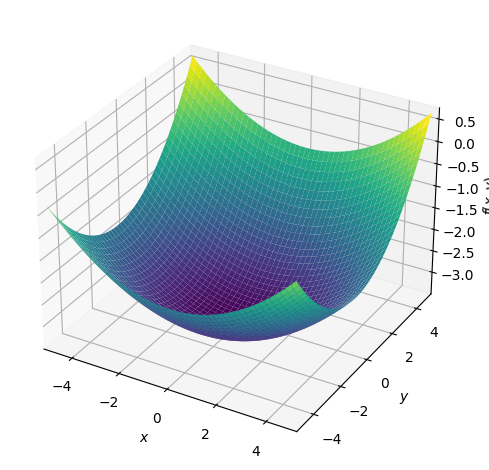

In [266]:
import surface_curvature
x, y = sympy.symbols("x y")
H = surface_curvature.symbolic.mean_curvature_explicit(f, (x,y))
display(H)
plot3d(H, (v[0], x_min, x_max), (v[1], y_min, y_max))

((3.3909282575879994e-12*x**2 - 2.2558408772948624e-13*x*y - 2.2133619643696074e-13*x + 1.3388025214860005e-11*y**2 - 1.7105418564231532e-12*y - 4.476280944767643e-10)*(8.367671039336611e-12*x**2 + 5.033473506764768e-13*x*y + 5.932104111972584e-13*x + 3.3909282575879994e-12*y**2 + 1.990679928411247e-11*y - 2.3380833589199126e-10) - 3.962806577379409e-22*(0.01264259872952544*x**2 + 0.34068040865758704*x*y + x - 0.0056660059839334362*y**2 - 0.011118623003026315*y - 0.09069996850997007)**2)/(2.0037091096489903e-19*(0.00018741277892936364*x**3 + 0.0075753249168859248*x**2*y + 0.022235868938679636*x**2 - 0.00025197713292903689*x*y**2 - 0.00049446448774776349*x*y - 0.004033585225060129*x + 0.0099696045147399754*y**3 - 0.0019106730313952008*y**2 - y - 0.67697534945058168)**2 + 5.4666337932582208e-20*(0.011929530523956015*x**3 + 0.0010764101903299979*x**2*y + 0.001268582681053969*x**2 + 0.014503025500144926*x*y**2 + 0.085141529313601989*x*y - x - 0.00016080413819070431*y**3 - 0.000473328283169

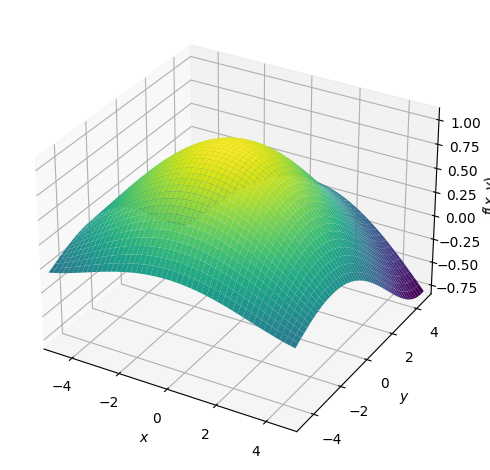

In [267]:
K = surface_curvature.symbolic.gaussian_curvature_explicit(f, (x,y))
display(K)
plot3d(K, (v[0], x_min, x_max), (v[1], y_min, y_max))

In [268]:
K, H, k1, k2, k1vec, k2vec = surface_curvature.symbolic.curvature_explicit(f, (x,y), (0,0))

display(K)

1.0465591987151090e-19

Discretize the function (Convert to 2D Vector) so we can easily find max and min

It makes sense to define an always positive number c, henceforth referred to as the ‘curvedness’, to specify the amount, or ‘intensity’ of the surface curvature. Although several alternative definitions would serve, I chose:
$$
C = \sqrt{\frac{\kappa_1^2 + \kappa_2^2}{2}}
$$
This is similar to the RMS equation, essentially stating that it is the positive valued mean curvature.

In [269]:
# plt.matshow(X)
# plt.matshow(Y)
# plt.matshow(Z)

In [270]:
xrange = np.linspace(x_min, x_max, nx)
yrange = np.linspace(y_min, y_max, ny)
X,Y = np.meshgrid(xrange, yrange)
Z = np.empty(shape=(ny, nx))

H_a = np.empty(shape=(ny, nx))
K_a = np.empty(shape=(ny, nx))
P_absmax_a = np.empty(shape=(ny, nx))
# Curvedness
C_a = np.empty(shape=(ny, nx))

k1X = np.empty(shape=(ny, nx))
k1Y = np.empty(shape=(ny, nx))
k1Z = np.empty(shape=(ny, nx))
k2X = np.empty(shape=(ny, nx))
k2Y = np.empty(shape=(ny, nx))
k2Z = np.empty(shape=(ny, nx))

In [271]:
# Symbolic Explicit 2D mean/gaussian curvature

for i in range(len(xrange)):
    for j in range(len(yrange)):
        Z[j, i] = f.subs({v[0]: xrange[i], v[1]: yrange[j]})

        # H_a[j, i] = H.subs({v[0]: x[i], v[1]: y[j]})
        # K_a[j, i] = K.subs({v[0]: x[i], v[1]: y[j]})

        point = [xrange[i],yrange[j]]
        K, H, k1, k2, k1vec, k2vec = surface_curvature.symbolic.curvature_explicit(f, (x,y), point)
        # print(K, H, k1, k2, k1vec, k2vec)

        P_absmax_a[j, i] = max([k1, k2], key=lambda x: abs(x))
        C_a[j, i] = sympy.sqrt((k1**2 + k2**2)/2)
        k1X[j, i] = k1vec[0] * k1
        k1Y[j, i] = k1vec[1] * k1
        k1Z[j, i] = k1vec[2] * k1
        k2X[j, i] = k2vec[0] * k2
        k2Y[j, i] = k2vec[1] * k2
        k2Z[j, i] = k2vec[2] * k2

In [272]:
## Finite curvature
# for i in range(len(xrange)):
#     for j in range(len(yrange)):
#         Z[j, i] = f.subs({v[0]: xrange[i], v[1]: yrange[j]})

# K, H, k1, k2, k1vec, k2vec = surface_curvature.discrete.curvature_discrete_parametric(X,Y,Z)

# for i in range(len(xrange)):
#     for j in range(len(yrange)):
#         P_absmax_a[j, i] = max([k1[j,i], k2[j,i]], key=lambda x: abs(x))
#         C_a[j, i] = sympy.sqrt((k1[j,i]**2 + k2[j,i]**2)/2)
#         k1X[j, i] = k1vec[:,:,0][j,i] * k1[j,i]
#         k1Y[j, i] = k1vec[:,:,1][j,i] * k1[j,i]
#         k1Z[j, i] = k1vec[:,:,2][j,i] * k1[j,i]
#         k2X[j, i] = k2vec[:,:,0][j,i] * k2[j,i]
#         k2Y[j, i] = k2vec[:,:,1][j,i] * k2[j,i]
#         k2Z[j, i] = k2vec[:,:,2][j,i] * k2[j,i]

In [273]:
print(X.shape)
print(k1X.shape)
print(C_a.shape)

(20, 20)
(20, 20)
(20, 20)


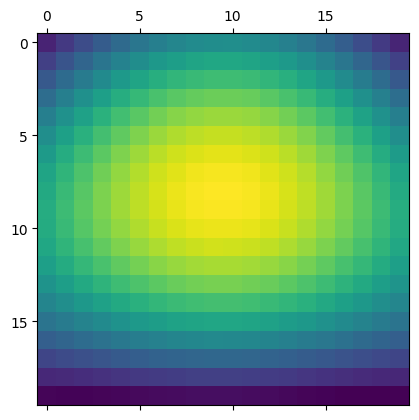

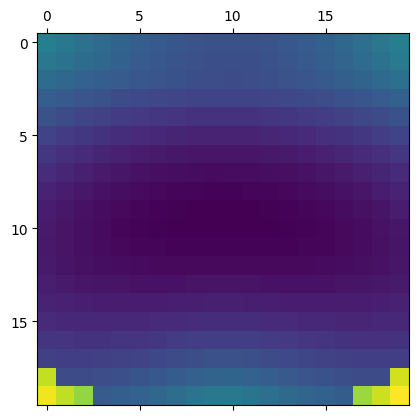

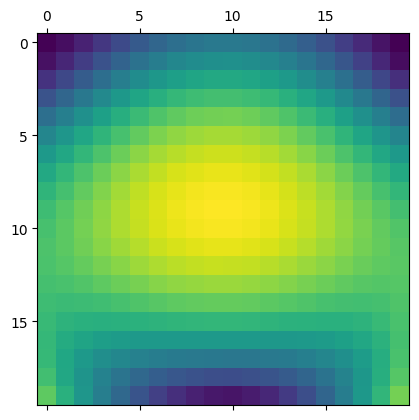

In [274]:
plt.matshow(Z)
# plt.matshow(H)
# plt.matshow(K)
plt.matshow(P_absmax_a)
plt.matshow(C_a)

In [275]:
print(f'{filename}')
print()
print('Prinicpal Curvature')
max_i,max_j = np.unravel_index(P_absmax_a.argmax(), P_absmax_a.shape)
min_i,min_j = np.unravel_index(P_absmax_a.argmin(), P_absmax_a.shape)
print(f'Min= {P_absmax_a.min()} rc={min_i,min_j} xy={min_j*resolution,min_i*resolution}')
print(f'Max= {P_absmax_a.max()} rc={max_i,max_j} xy={max_j*resolution,max_i*resolution}')
print(f'Avg= {P_absmax_a.mean()}')
print(f"Absolute maximum principal curvature: {max([P_absmax_a.max(), P_absmax_a.min()], key=lambda x: abs(x))}")
print()
print('Curvedness')
max_i,max_j = np.unravel_index(C_a.argmax(), C_a.shape)
min_i,min_j = np.unravel_index(C_a.argmin(), C_a.shape)
print(f'Min= {C_a.min()} rc={min_i,min_j} xy={min_j*resolution,min_i*resolution}')
print(f'Max= {C_a.max()} rc={max_i,max_j} xy={max_j*resolution,max_i*resolution}')
print(f'Avg= {C_a.mean()}')

C:\Users\phcre\Documents\Notebook/7_SurfaceDisplacement.txt

Prinicpal Curvature
Min= -4.47103349547678e-10 rc=(10, 9) xy=(4.5, 5.0)
Max= 3.5686190574665184e-10 rc=(19, 19) xy=(9.5, 9.5)
Avg= -3.162985776336974e-10
Absolute maximum principal curvature: -4.47103349547678e-10

Curvedness
Min= 7.638652611000938e-11 rc=(0, 19) xy=(9.5, 0.0)
Max= 3.5762374691996575e-10 rc=(9, 9) xy=(4.5, 4.5)
Avg= 2.548695131716617e-10


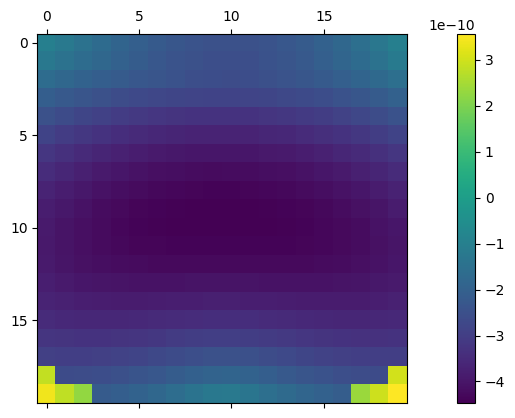

In [276]:
fig = plt.figure()
ax = fig.add_subplot(111)
pcm = ax.matshow(P_absmax_a) 
fig.colorbar(pcm, pad=0.1)

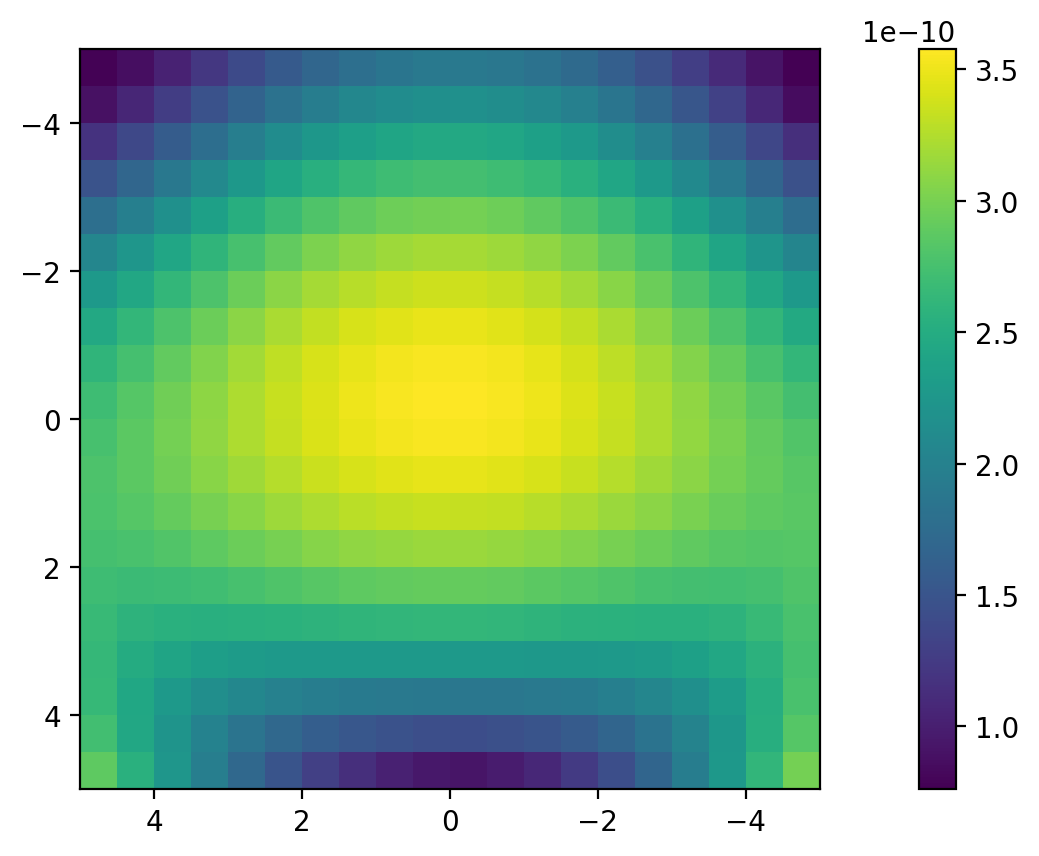

In [277]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
pcm = ax.imshow(C_a, extent=[x_max, x_min, y_max, y_min])
fig.colorbar(pcm, pad=0.1)

Text(0, 0.5, 'Curvedess: C(x,y)')

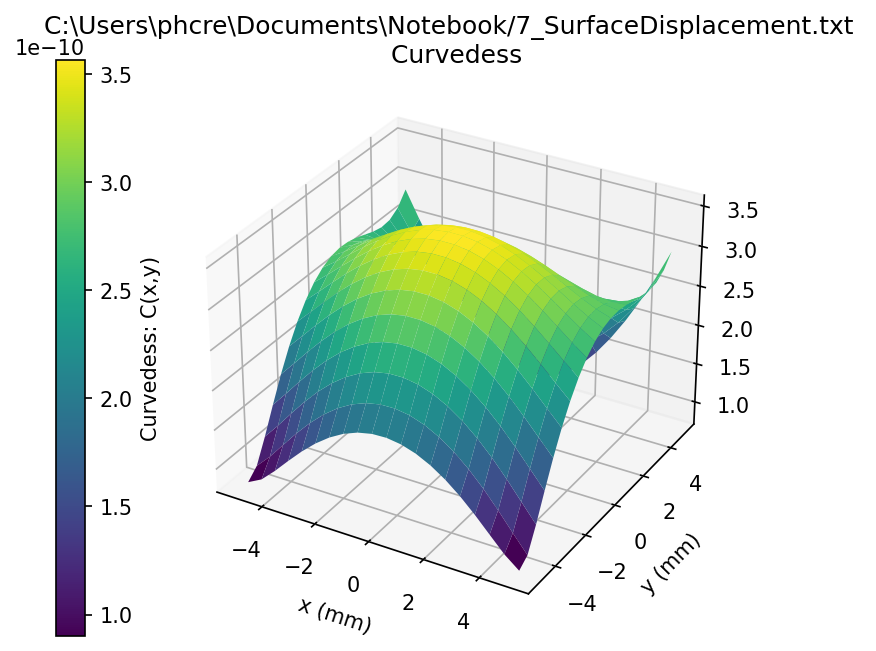

In [278]:
X, Y = np.meshgrid(xrange, yrange)

fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
plt.title(f'{filename} \n Curvedess')
asm = ax.plot_surface(X, Y, C_a, cmap='viridis') # cmap='viridis' / cmap='PiYG'
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8]) 
fig.colorbar(asm, cax = cbaxes)
plt.ylabel("Curvedess: C(x,y)")
# ax.view_init(30, -125)

In [279]:
fig = go.Figure(
    data=[
        go.Cone(
            x=X.ravel(),
            y=Y.ravel(),
            z=Z.ravel()*100,
            u=k2X.ravel(), # YXZ
            v=k2Y.ravel(),
            w=k2Z.ravel()*100,
            sizemode="absolute",
            # sizeref=0.0005,
            anchor="tip",
            name="k2",
            hovertemplate="x: %{x}\ny: %{y}\nz: %{z}\n\nu: %{u}\nv: %{v}\nw: %{w}"
        ),
        go.Cone(
            x=X.ravel(),
            y=Y.ravel(),
            z=Z.ravel()*100,
            u=k1X.ravel(),
            v=k1Y.ravel(),
            w=k1Z.ravel()*100,
            sizemode="absolute",
            # sizeref=0.0005,
            anchor="tip",
            name="k1",
            hovertemplate="x: %{x}\ny: %{y}\nz: %{z}\n\nu: %{u}\nv: %{v}\nw: %{w}"
        ),
    ]
)
fig.add_trace(go.Surface(x=X, y=Y, z=Z*100))
fig.show()